In [9]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [10]:
# ========== LOAD DATA ==========
DATA_DIR = os.path.join('..', '..', 'data', 'cleaned','joblib_dataframes')

movies = joblib.load(os.path.join(DATA_DIR, 'df_movies_combined_rf.joblib'))
movies = movies.select_dtypes(exclude='object')  # drop all string columns asap

if 'imdb_id' in movies.columns:
    movies = movies.drop(columns=['imdb_id'])

In [11]:
# ========== SET TARGET ==========
y = (movies['box_office_$'] > 100_000_000).astype(int)
X = movies.drop(columns=['box_office_$'])

X = X.fillna(0).astype(np.float32)  # convert to 32-bit for less RAM
X_sparse = csr_matrix(X.values)

In [12]:
# ========== FEATURE SELECTION ==========
selector = SelectKBest(score_func=chi2, k=10_000)  # Try k=500 or 1000 first
X_reduced = selector.fit_transform(X_sparse, y)

# Get the selected feature names from the original DataFrame columns
selected_features = X.columns[selector.get_support()]

In [13]:
# ========== SPLIT ==========
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [14]:
# ========== TRAIN ==========
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)


Training set size: 4001 samples
Testing set size: 1001 samples
Accuracy: 0.8402
**************************************************

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       841
           1       0.00      0.00      0.00       160

    accuracy                           0.84      1001
   macro avg       0.42      0.50      0.46      1001
weighted avg       0.71      0.84      0.77      1001

**************************************************

Confusion Matrix:


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


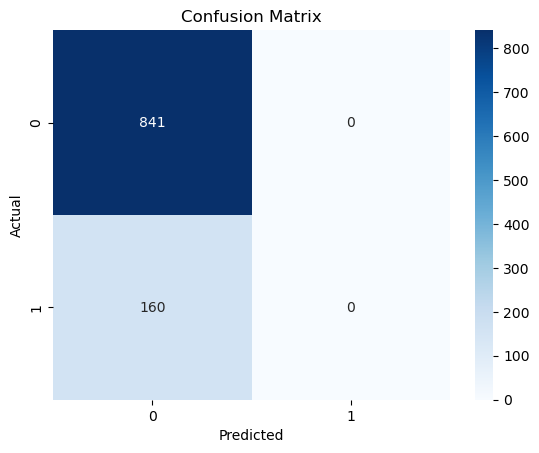

In [15]:
# ========== PREDICT & EVALUATIE ==========
y_pred = model.predict(X_test)

print(f"\nTraining set size: {X_train.shape[0]} samples") #.shape[0] = number of samples (rows)
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(50*'*')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(50*'*')

print("\nConfusion Matrix:")
# confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

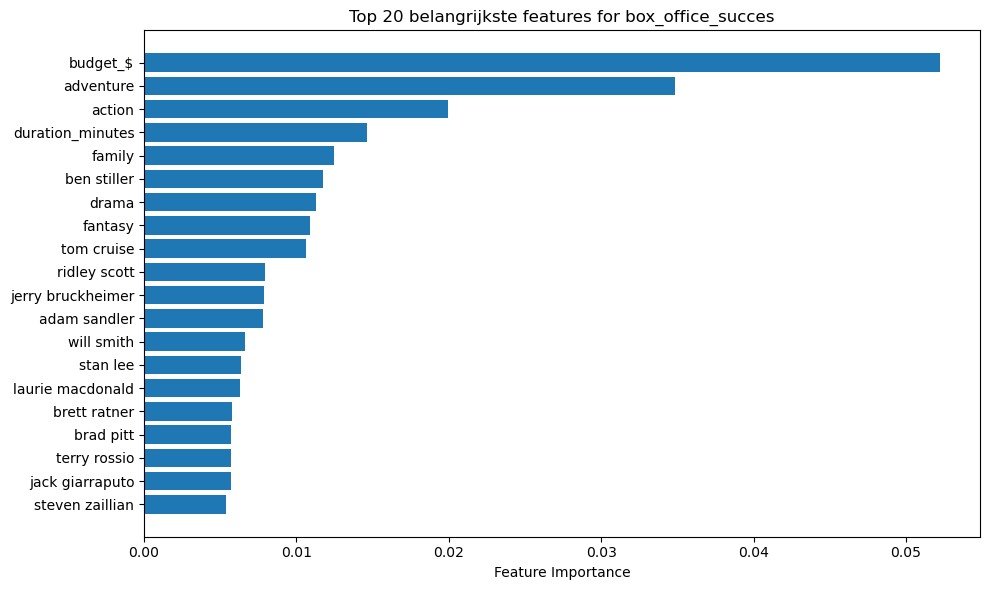

In [16]:
# ========== PLOT FEATURE IMPORTANCES ==========
importances = pd.Series(model.feature_importances_, index=selected_features)

top_n = 20
top_features = importances.nlargest(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features.index[::-1], top_features.values[::-1])  # reversed for descending order
plt.xlabel("Feature Importance")
plt.title("Top 20 belangrijkste features for box_office_succes")
plt.tight_layout()
plt.show()